# Predicting Handwritten Digit with Multiclass Logistic Regression

## Overview
In this post, I will implement a basic character recognition system of handwritten digits using Multiclass Logistic Regression in R with Kaggle dataset - [mnist_test][id].

[id]: https://www.kaggle.com/oddrationale/mnist-in-csv "dataset"

## Introduction
Generalized Linear Model (GLM) is a flexible generalization of ordinary linear regression. To be more specific, GLM allows for response variables that have error distribution models other than a normal distribution. For instance, when a target is a discrete variable, we can apply the Poisson Regression Model. In the following work, I will apply another type of GLM, Logistic Regression Model, to predict handwritten digits. Since this is a multiclass classification, I will apply Multiclass Logistic Regression, also called Multinomial Logistic or Softmax Regression.

## Dataset Overview
The "mnist_test" is a dataset containing 10,000 of 28x28 grayscale images. Each image is encoded as a row of 784 (28x28) integer values between 0 and 255 indicating the brightness of each pixel. The label associated with each image is encoded as an integer value between 0 and 9. Overall, there are 785 columns in the dataset, where the first column corresponds to the digit labels (0-9), and the remaining 784 columns correspond to the pixel-values of the associated image. To predict a digit, the first column is used as the target variable.

In [ ]:
# Load library
library(RcppNumerical)
library(tidyverse)
library(optimx)
library(knitr)
library(caret)
library(Rgraphviz)
library(ggplot2)
library(plyr)

In [2]:
# Load data
df <- read.csv(file = "mnist_test.csv", header=FALSE)

In [3]:
head(df, 3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V776,V777,V778,V779,V780,V781,V782,V783,V784,V785
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,7,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
# 10000 rows, 785 columns
dim(df)

[1] 10000   785

### Plot Images

In [5]:
# Create functions to plot image
rotate <- function(x) {
  return(t(apply(x, 2, rev)))
}

plot_matrix <- function(vec) {
  q <- matrix(vec, 28, 28, byrow = TRUE)
  nq <- apply(q, 2, as.numeric)
  image(rotate(nq), col = gray((0:255)/255))
}

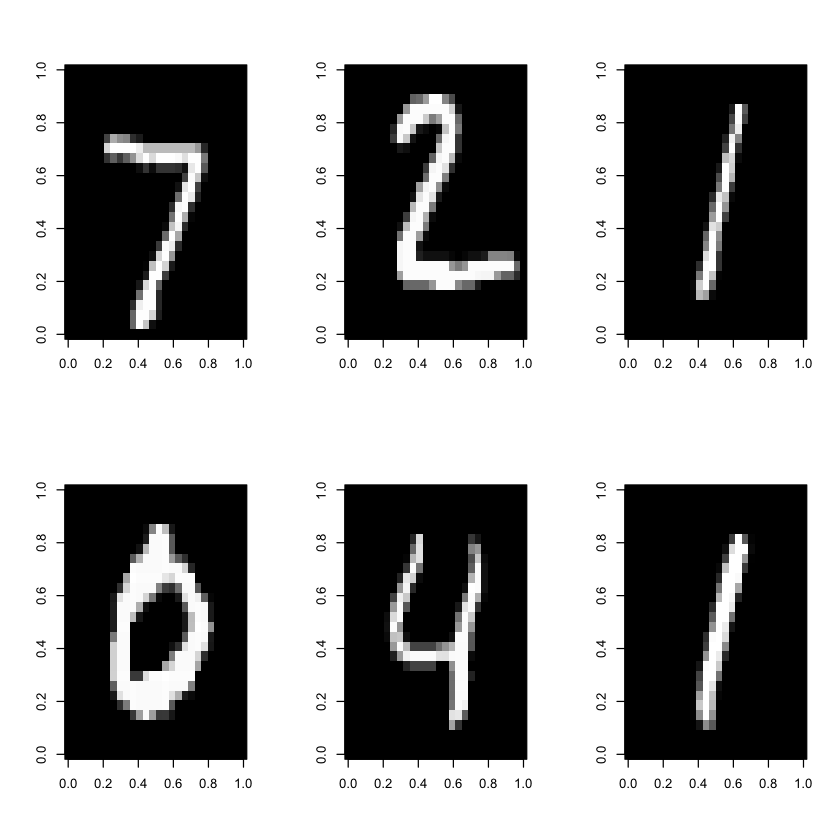

In [6]:
# Plot first 6 images
par(mfrow = c(2, 3))
loop <- 1:6
for (i in loop) { 
    plot_matrix(df[i, 2:785])
}

### Digit Labels Distribution 

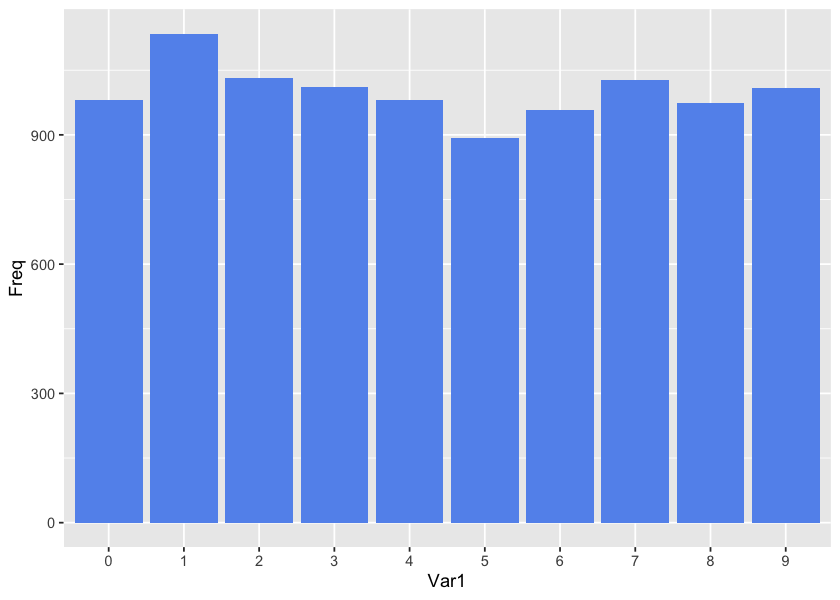

In [14]:
# Examine first column data (digit labels 0-9)
options(repr.plot.width = 7, repr.plot.height = 5)
digit_table <- as.data.frame(table(df$V1))
ggplot(digit_table, aes(x=Var1, y=Freq)) + geom_bar(stat="identity", fill="cornflowerblue")

From the bar chart above, we can tell that there are 10 digit labels and the distribution of them are quite equal. That is, the dataset is quite balanced.

## Data Preprocessing

### 1. Examine Missing Value

In [8]:
# Examin Na 
sum(is.na(df))

[1] 0

### 2. Split into Training and Test

I split the dataset into 80% training and 20% test.

In [9]:
set.seed(2022)
train_ind <- sample(seq_len(nrow(df)), size = 0.8*nrow(df))
train <- df[train_ind,]
test <- df[-train_ind,]

## Data Modeling
### 1. Build 10 Logistic Regression Models (one per digit)
Regarding the dependent variable (Y) for each logistic regression model, I relabeled the first column with a 1 if it corresponded to the digit I was training for, and 0 otherwise. Besides, I built a for loop to train 10 models and predict on the test dataset.

In [ ]:
# 10 digit labels
for (i in 0:9)
  {
  train_loop <- train
  # Relabel (when digit=i, 1 ; Otherwise, 0)
  train_loop$V1 = ifelse(train_loop$V1==i, 1, 0)
  # Build Models
  GLM <- glm(V1~., family=binomial(link = "logit"), data=train_loop, maxit = 1000)
  # Assign prediction GLM_(0~9)
  assign(paste("GLM", i, sep = "_"), predict(GLM, newdata = test))
}

### 2. Softmax Function
After using 10 models to predict on the test dataset, I obtained 10 probabilities per image. Thus, for each image, to transform those unrelated probabilities into a probability distribution over the ten digits, I created a Softmax function. The predicted digit will be the one associated with the maximum probability. <br />
The Softmax function is used in various multiclass classification methods. To be more specific, <strong>it turns a vector of K real values into a vector of K real values that sum to 1</strong>. Thus, after transforming those unrelated probabilities, for each image, the sum of the probabilities over the ten digits will become 1.

In [11]:
softmax_function <- function(par){
  n.par <- length(par)
  par1 <- sort(par, decreasing = TRUE)
  Lk <- par1[1]
  for (k in 1:(n.par-1)) {
    Lk <- max(par1[k+1], Lk) + log1p(exp(-abs(par1[k+1] - Lk))) 
  }
  val <- exp(par - Lk)
  return(val)
}

In [12]:
Predict_list <- c()

# Unrelated probabilities -> related probability, using Softmax_function
for(i in 1:2000){
  Unrelated_Prob <- c(GLM_0[i], GLM_1[i], GLM_2[i], GLM_3[i], GLM_4[i],
                      GLM_5[i], GLM_6[i], GLM_7[i], GLM_8[i], GLM_9[i])
  Related_Prob <- softmax_function(Unrelated_Prob)
  # Find maximum probability
  Max_digit <- which(Related_Prob==max(Related_Prob))-1
  # Store predicted result
  Predict_list[[i]] <- Max_digit
  }

### 3. Evaluate Model Performance
A confusion matrix is a table with the counts of the correct and incorrect classifications. From the table results, we can tell that overall, the accuracy is around 76%. Also, since this is a multiclass classification, I would like to examine the True Positive Rate (Sensitivity/ Recall) of each digit. We can tell that digit 1 has the highest TPR, above 90%, and digits 0 and 7 also have high TPR, above 80%. However, digits 5 and 8 have lower TPR, only around 65%. THat is to say, our model can highly correctly recognize handwritten digits of 1, 0, and 7, but can not recognize handwritten digits of 5 and 8 very well.

In [13]:
Actual_list <- test[,1]
confusionMatrix(factor(Predict_list[], levels=0:9),factor(Actual_list[], levels=0:9))

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4   5   6   7   8   9
         0 155   0  11  10   0  10   3   2  13  14
         1   1 198   8  10   2  10   1   5  19   4
         2  10   6 141   4   7   1   7   3   3   1
         3   0   1   3 144   6  10   2   5   7   2
         4   1   1   2   3 145   5   4   7  10  12
         5  10   2   4  10   3 118  13   0   4   4
         6   1   0   3   3   3  14 144   3   4   3
         7   5   2   7   6   3   6   4 172   7  16
         8   5   7   5   2   5   9  16   4 135   6
         9   0   0   3   2  25   2   2   5   3 161

Overall Statistics
                                          
               Accuracy : 0.7565          
                 95% CI : (0.7371, 0.7752)
    No Information Rate : 0.1115          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7293          
                                          
 Mcnemar's Test P-Valu

## Conclusion
To sum up, I trained 10 models, one per digit. Then, I used each model to predict on the test dataset, which contains 3000 images, so I got a total of 10x3000=30000 probabilities (10 probabilities per image). For each image, I used the Softmax function to turn those 10 unrelated probabilities into 10 related probabilities. Based on the 10 related probabilities, the predicted digit for each image is the one associated with the maximum probability. Finally, with predicted results, I built a confusion matrix and calculated the overall accuracy.<br />
Overall, under the assumption that the classes are mutually exclusive, softmax regression (multiclass logistic regression) is a generalization of logistic regression that we can use for multiclass classification.

## References
Generalized Linear Models. (2020, December 23). Retrieved from
https://www.jmp.com/support/help/en/15.2/index.shtml#page/jmp/generalized-linear-models.shtml <br />
Kida, Y. (2019, September 23). <I>Generalized linear models</I>. Retrieved from
https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab <br />
What is Softmax Regression and How is it Related to Logistic Regression? (n.d.). Retrieved from https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html <br />
Wood, T. (n.d.). <I>Softmax Function</I>. Retrieved from
https://deepai.org/machine-learning-glossary-and-terms/softmax-layer